In [171]:
# The mission of this notebook is to get sentinel-hub satellital images from Michoacan    
# Let's import important libraries
import geopandas
import datetime
from tqdm import tqdm_notebook as tqdm
from os import path as op
import pandas as pd
from sentinelhub import CRS, BBoxSplitter, DataCollection
from eolearn.core import EOTask, FeatureType, SaveTask, OverwritePermission, LinearWorkflow
from eolearn.io import *

In [172]:
# Write the name of the geojson file
place = 'mexican_states'

# Write the path where you have your geojsons
path_file = f'../../raw_data/geojsons/{place}.geojson'

# Open the geojson as a geodataframe
states = geopandas.read_file(path_file)

# Let's visualize how the geodataframe looks like
states

,objectid,fips_admin,gmi_admin,admin_name,fips_cntry,gmi_cntry,cntry_name,pop_admin,type_eng,type_loc,sqkm,sqmi,color_map,shape_leng,shape_area,cartodb_id,created_at,updated_at,geometry
0,1069,MX22,MEX-QDA,Queretaro,MX,MEX,Mexico,1143544,State,Estado,12094.60,4669.73,11,5.666211,1.046724,13,2014-08-19T17:34:57+00:00,2014-08-19T17:34:57+00:00,"MULTIPOLYGON (((-100.12280 19.93804, -100.1247..."
1,1114,MX09,MEX-DTD,Distrito Federal,MX,MEX,Mexico,9724226,Federal District,Distrito Federal,1342.75,518.44,3,1.312898,0.115048,23,2014-08-19T17:34:57+00:00,2014-08-19T17:34:57+00:00,"MULTIPOLYGON (((-99.28487 19.14244, -99.28445 ..."
2,1111,MX08,MEX-COL,Colima,MX,MEX,Mexico,466124,State,Estado,5747.09,2218.95,2,3.207906,0.492006,22,2014-08-19T17:34:57+00:00,2014-08-19T17:34:57+00:00,"MULTIPOLYGON (((-103.74548 18.68807, -103.7551..."
3,1117,MX17,MEX-MRL,Morelos,MX,MEX,Mexico,1299939,State,Estado,5007.61,1933.44,2,2.959913,0.427726,24,2014-08-19T17:34:57+00:00,2014-08-19T17:34:57+00:00,"MULTIPOLYGON (((-98.66223 18.99676, -98.64820 ..."
4,1057,MX01,MEX-AGS,Aguascalientes,MX,MEX,Mexico,782890,State,Estado,5609.14,2165.69,4,2.807425,0.489324,10,2014-08-19T17:34:57+00:00,2014-08-19T17:34:57+00:00,"MULTIPOLYGON (((-101.84621 22.01176, -101.8714..."
5,888,MX06,MEX-CHH,Chihuahua,MX,MEX,Mexico,2656214,State,Estado,247935.02,95727.70,12,22.609277,22.890985,1,2014-08-19T17:34:57+00:00,2014-08-19T17:34:57+00:00,"MULTIPOLYGON (((-103.63086 26.66108, -103.6650..."
6,1067,MX11,MEX-GNJ,Guanajuato,MX,MEX,Mexico,4332525,State,Estado,30466.18,11762.99,10,8.460881,2.637568,12,2014-08-19T17:34:57+00:00,2014-08-19T17:34:57+00:00,"MULTIPOLYGON (((-100.28032 20.20451, -100.2955..."
7,933,MX07,MEX-CDZ,Coahuila,MX,MEX,Mexico,2145539,State,Estado,150843.95,58240.87,2,18.993090,13.733655,2,2014-08-19T17:34:57+00:00,2014-08-19T17:34:57+00:00,"MULTIPOLYGON (((-102.66695 25.07583, -102.7189..."
8,976,MX19,MEX-NLE,Nuevo Leon,MX,MEX,Mexico,3370912,State,Estado,65173.05,25163.31,3,15.426171,5.844668,3,2014-08-19T17:34:57+00:00,2014-08-19T17:34:57+00:00,"MULTIPOLYGON (((-99.71390 27.66894, -99.85918 ..."
9,978,MX28,MEX-TML,Tamaulipas,MX,MEX,Mexico,2272724,State,Estado,79502.24,30695.81,11,18.023144,7.056563,4,2014-08-19T17:34:57+00:00,2014-08-19T17:34:57+00:00,"MULTIPOLYGON (((-98.61609 22.41849, -98.63028 ..."


The dimension of Michoacan is 752238.7201971486 x 956137.624034211 m2


/Users/eduardobetancourthernandez/.pyenv/versions/3.7.7/envs/lewagon/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


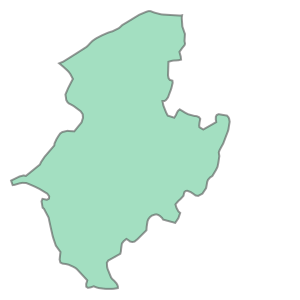

In [173]:
# Now let's get important information from our geodataframe to make the API request

crs = CRS.UTM_31N

# Set your desired state as your aoi
aoi = states[states['admin_name'] == 'Michoacan'] 
aoi_name = aoi.admin_name.values[0]

# Change crs of geometry multiploygon to compatible CRS
aoi = aoi.to_crs(crs=crs.pyproj_crs())

# Extract the shape of the aoi
aoi_shape = aoi.geometry.values[-1]

# Get the height and width of the aoi
W = (aoi_shape.bounds[2] - aoi_shape.bounds[0])
H = (aoi_shape.bounds[3] - aoi_shape.bounds[1])

print(f"The dimension of {aoi_name} is {W} x {H} m2")

# Return the shape to visualize the aoi
aoi_shape

In [197]:
# Select the time interval 
time_interval = ('2018-01-01', '2018-12-30')

# Which height and width you want your images to be
w = 2400
h = 2400

# Calculates into how many eopatch rows and columns the aoi will be split into
x_boxes = round(W / (w*10))
y_boxes = round(H / (h*10)) 

# Split the aoi into its boxes
bbox_splitter = BBoxSplitter([aoi_shape], crs, (x_boxes, y_boxes))

print(f"You will create a grid {x_boxes} * {y_boxes} = {x_boxes*y_boxes} boxes of size {round(H/(y_boxes*10))} x {round(W/(x_boxes*10))} for {aoi_name}")

You will create a grid 31 * 40 = 1240 boxes of size 2390 x 2427 for Michoacan


In [198]:
# create a task for calculating a median pixel value
class MedianPixel(EOTask):
    """
    The task returns a pixelwise median value from a time-series and stores the results in a 
    timeless data array.
    """
    def __init__(self, feature, feature_out):
        self.feature_type, self.feature_name = next(self._parse_features(feature)())
        self.feature_type_out, self.feature_name_out = next(self._parse_features(feature_out)())

    def execute(self, eopatch):
        eopatch.add_feature(self.feature_type_out, self.feature_name_out, 
                            np.median(eopatch[self.feature_type][self.feature_name], axis=0))
        return eopatch

In [199]:
# initialize tasks
# task to get S2 L2A images

input_task = SentinelHubInputTask(data_collection=DataCollection.SENTINEL2_L2A, 
                                     bands_feature=(FeatureType.DATA, 'BANDS'),
                                     resolution=10, 
                                     maxcc=0.2, 
                                     bands=['B04', 'B03', 'B02'], 
                                     time_difference=datetime.timedelta(hours=2),
                                     additional_data=[(FeatureType.MASK, 'dataMask', 'IS_DATA')]
                                    )

# task to compute median values
get_median_pixel = MedianPixel((FeatureType.DATA, 'BANDS'), 
                               feature_out=(FeatureType.DATA_TIMELESS, 'MEDIAN_PIXEL'))
# task to save to disk
save = SaveTask(op.join('..', '..','raw_data', 'eopatch'), 
                  overwrite_permission=OverwritePermission.OVERWRITE_PATCH, 
                  compress_level=2)

In [200]:
# initialize workflow
workflow = LinearWorkflow(input_task, get_median_pixel, save)

In [201]:
# use a function to run this workflow on a single bbox
def execute_workflow(index):
    bbox = bbox_splitter.bbox_list[index]
    info = bbox_splitter.info_list[index]
    
    patch_name = f"{aoi_name}_eopatch_{index}_row-{info['index_x']}_col-{info['index_y']}"
    
    results = workflow.execute({input_task:{'bbox':bbox, 'time_interval':time_interval},
                                save:{'eopatch_folder':patch_name}
                               })
    return list(results.values())[-1]
    del results 

In [202]:
%%time
subset_idx = len(bbox_splitter.bbox_list)
pbar = tqdm(total=subset_idx)
for idx in range(0, subset_idx):
    patch = execute_workflow(idx)
    pbar.update(1)

/Users/eduardobetancourthernandez/.pyenv/versions/3.7.7/envs/lewagon/lib/python3.7/site-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


ValueError: During execution of task SentinelHubInputTask: No available images for requested time range: ('2018-01-01T00:00:00', '2018-12-30T23:59:59')